# Demand Forecasting using Tree-based Regression : Random Forest 

By Team Nugget - Crystal Liu, Daria Zhan, Mei Yang, Pallavi Sama, Sarah Gustafson

MSBA | UC Davis | 442-Advance Statistics | Final Project 

March 9th, 2018

<img src="Picture1.png",height=300, width=600>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Libraries-&amp;-Data" data-toc-modified-id="Importing-Libraries-&amp;-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Libraries &amp; Data</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Exploratory-Data-Analyses-&amp;-Visualization" data-toc-modified-id="Exploratory-Data-Analyses-&amp;-Visualization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analyses &amp; Visualization</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Model-Development" data-toc-modified-id="Model-Development-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Development</a></span></li><li><span><a href="#Prediction-&amp;-Validation" data-toc-modified-id="Prediction-&amp;-Validation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Prediction &amp; Validation</a></span></li></ul></div>

### Importing Libraries & Data

In [1]:
# Importing the required libraries
library(dplyr)
library(ggplot2)
library(randomForest)
library(party)
library(reshape2)
library(repr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich


In [40]:
# To replicate the results
set.seed(1)

# Reading the datasets
train <- read.csv("../input/train.csv")
store <- read.csv("../input/store.csv")

# Merge to get the store info into datasets
train <- merge(train,store)

# Let's get a quick glimpse on the dataset
glimpse(train)
summary(train)

Observations: 1,017,209
Variables: 12
$ Store               <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ DayOfWeek           <int> 5, 6, 5, 3, 3, 7, 3, 1, 5, 1, 6, 3, 6, 4, 3, 4,...
$ Date                <fct> 2015-07-31, 2013-01-12, 2014-01-03, 2014-12-03,...
$ Sales               <int> 5263, 4952, 4190, 6454, 3310, 0, 3591, 4770, 38...
$ Customers           <int> 555, 646, 552, 695, 464, 0, 453, 542, 466, 480,...
$ Open                <int> 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ Promo               <int> 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,...
$ StateHoliday        <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ SchoolHoliday       <int> 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,...
$ StoreType           <fct> c, c, c, c, c, c, c, c, c, c, c, c, c, c, c, c,...
$ Assortment          <fct> a, a, a, a, a, a, a, a, a, a, a, a, a, a, a, a,...
$ CompetitionDistance <int> 1270, 1270, 1270, 1270, 1270, 1270, 1270, 1270,...


     Store          DayOfWeek             Date             Sales      
 Min.   :   1.0   Min.   :1.000   2013-01-02:   1115   Min.   :    0  
 1st Qu.: 280.0   1st Qu.:2.000   2013-01-03:   1115   1st Qu.: 3727  
 Median : 558.0   Median :4.000   2013-01-04:   1115   Median : 5744  
 Mean   : 558.4   Mean   :3.998   2013-01-05:   1115   Mean   : 5774  
 3rd Qu.: 838.0   3rd Qu.:6.000   2013-01-06:   1115   3rd Qu.: 7856  
 Max.   :1115.0   Max.   :7.000   2013-01-07:   1115   Max.   :41551  
                                  (Other)   :1010519                  
   Customers           Open            Promo        StateHoliday
 Min.   :   0.0   Min.   :0.0000   Min.   :0.0000   0:986159    
 1st Qu.: 405.0   1st Qu.:1.0000   1st Qu.:0.0000   a: 20260    
 Median : 609.0   Median :1.0000   Median :0.0000   b:  6690    
 Mean   : 633.1   Mean   :0.8301   Mean   :0.3815   c:  4100    
 3rd Qu.: 837.0   3rd Qu.:1.0000   3rd Qu.:1.0000               
 Max.   :7388.0   Max.   :1.0000   Max.   

### Data Cleaning

In [41]:
# There are some NAs in the competition distance column, so let us impute that with the median
train$CompetitionDistance[is.na(train$CompetitionDistance)] <- median(train$CompetitionDistance, na.rm=TRUE)
summary(train$CompetitionDistance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     20     710    2330    5422    6880   75860 

In [42]:
# Removing the stores that were closed
train <- train[which(train$Open == '1'),]

# Extracting the elements of the date column
train$month <- as.integer(format(as.Date(train$Date), "%m"))
train$year <- as.integer(format(as.Date(train$Date), "%Y"))
train$day <- as.integer(format(as.Date(train$Date), "%d"))

# Converting the categorical integer data to factor 
train$Store <- as.factor(train$Store)
train$DayOfWeek <- as.factor(train$DayOfWeek)
train$Open <- as.factor(train$Open)
train$Promo <- as.factor(train$Promo)
train$StateHoliday <- as.factor(ifelse(train$StateHoliday == '0', 0, 1))
train$SchoolHoliday <- as.factor(train$SchoolHoliday)
train$month <- as.factor(train$month)
train$year <- as.factor(train$year)

### Exploratory Data Analyses & Visualization

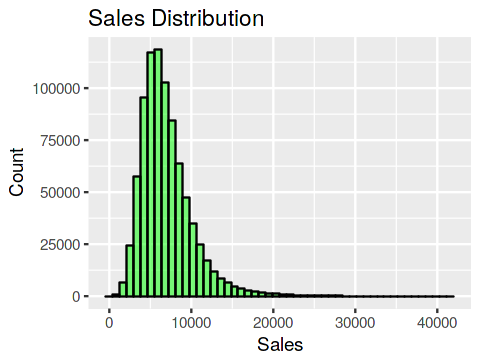

In [5]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of Sales
ggplot(data=train, aes(train$Sales)) + 
  geom_histogram(bins=50, col="black", fill="green", alpha = .5) + 
  labs(title="Sales Distribution") +
  labs(x="Sales", y="Count")

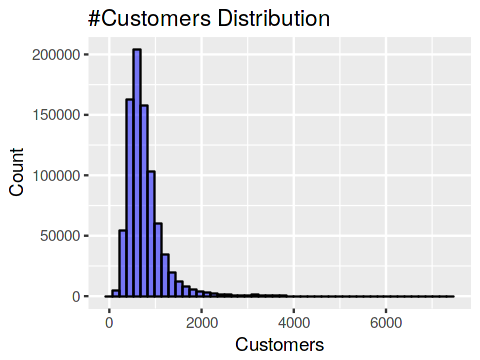

In [6]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of Customers
ggplot(data=train, aes(train$Customers)) + 
  geom_histogram(bins=50, col="black", fill="blue", alpha = .5) + 
  labs(title="#Customers Distribution") +
  labs(x="Customers", y="Count")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


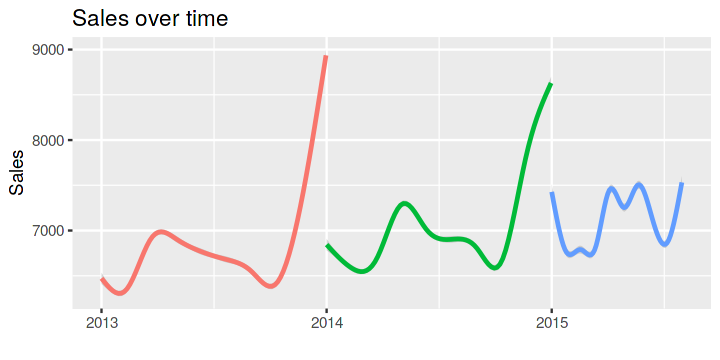

In [14]:
options(repr.plot.width=6, repr.plot.height=3)
# Line chart to show sales over time
ggplot(train, aes(x = as.Date(Date), y = Sales, color = factor(year))) + 
  geom_smooth() +
  labs(title="Sales over time") +
  labs(x="", y="Sales") +
  guides(color=FALSE)

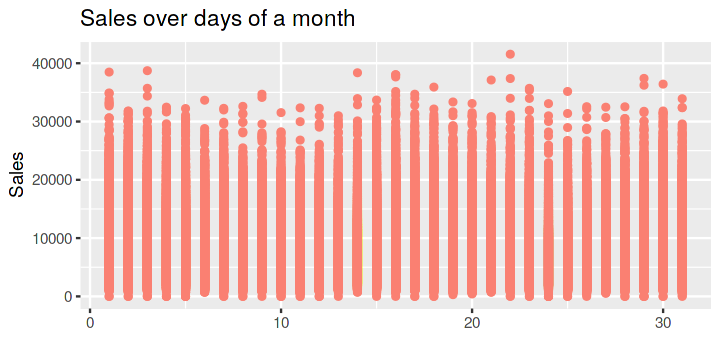

In [15]:
options(repr.plot.width=6, repr.plot.height=3)
# Sales over days of a month
ggplot(train, aes(x = day, y = Sales)) + 
  geom_point(col="salmon") +
  labs(title="Sales over days of a month") +
  labs(x="", y="Sales")

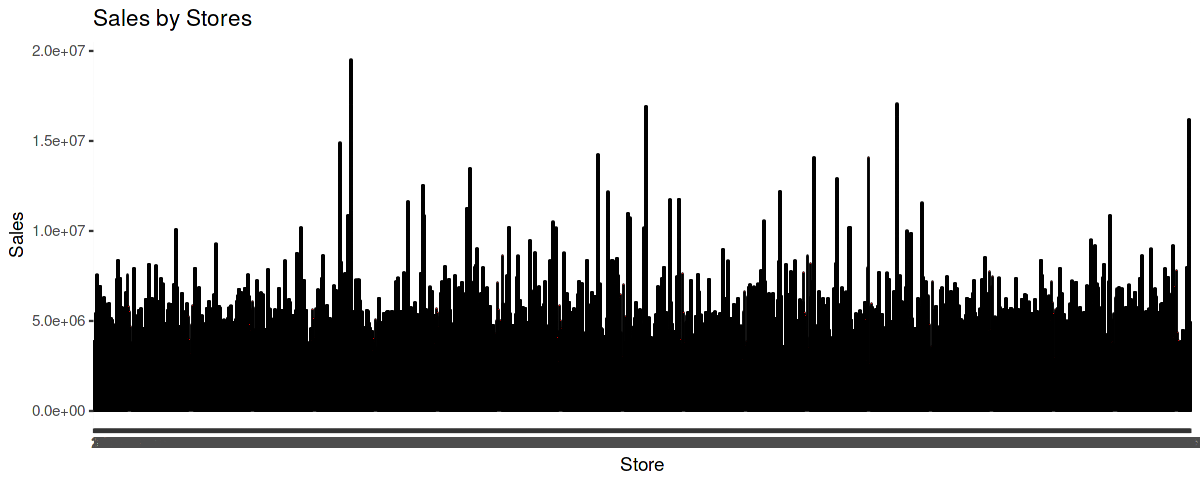

In [16]:
options(repr.plot.width=10, repr.plot.height=4)
# Distribution of Sales by Store ID
ggplot(data=train, aes(x=train$Store, y=train$Sales)) + 
  geom_bar(stat="identity",col="black", fill="red", alpha = .3) + 
  labs(title="Sales by Stores") +
  labs(x="Store", y="Sales")

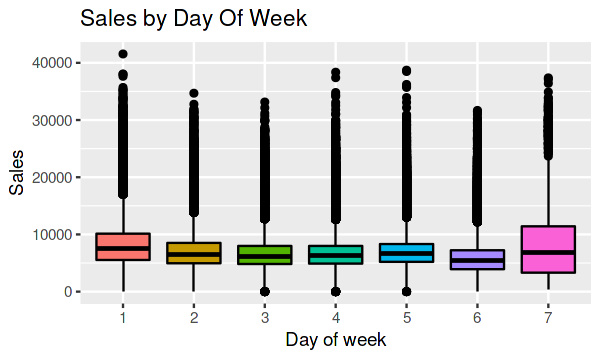

In [17]:
options(repr.plot.width=5, repr.plot.height=3)
# Distribution by day of the week
ggplot(train, aes(x = factor(DayOfWeek), y = Sales, fill=DayOfWeek)) +
  geom_boxplot(color = "black") +
  labs(title="Sales by Day Of Week") +
  labs(x="Day of week", y="Sales") +
  guides(fill=FALSE)

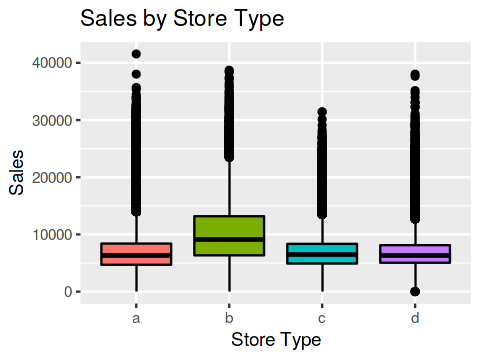

In [18]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution by Store type
ggplot(train, aes(x = factor(StoreType), y = Sales, fill=StoreType)) +
  geom_boxplot(color = "black") +
  labs(title="Sales by Store Type") +
  labs(x="Store Type", y="Sales") +
  guides(fill=FALSE)

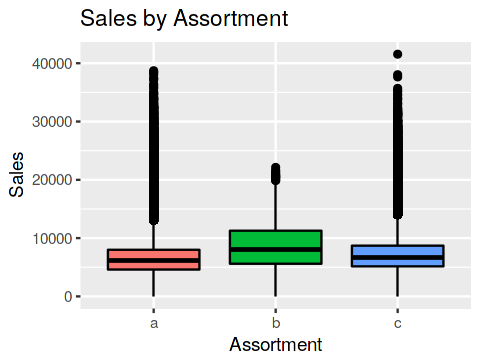

In [19]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution by Assortment
ggplot(train, aes(x = factor(Assortment), y = Sales, fill=Assortment)) +
  geom_boxplot(color = "black") +
  labs(title="Sales by Assortment") +
  labs(x="Assortment", y="Sales") +
  guides(fill=FALSE)

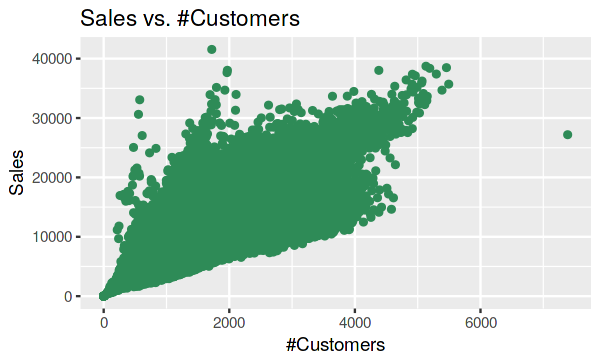

In [20]:
options(repr.plot.width=5, repr.plot.height=3)
# Sales vs. Customers
ggplot(train, aes(x = Customers, y = Sales)) + 
  geom_point(col="seagreen") +
  labs(title="Sales vs. #Customers") +
  labs(x="#Customers", y="Sales")

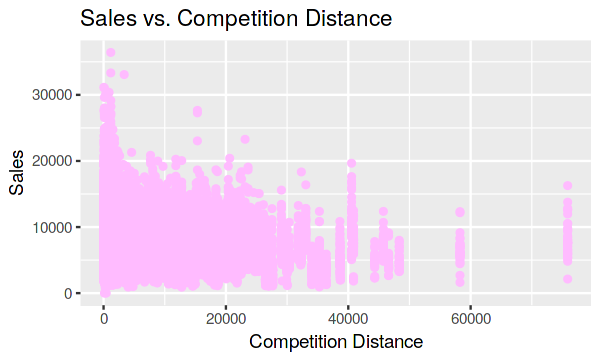

In [39]:
options(repr.plot.width=5, repr.plot.height=3)
# Sales vs. Competition Distance
ggplot(train, aes(x = CompetitionDistance, y = Sales)) + 
  geom_point(col="plum1") +
  labs(title="Sales vs. Competition Distance") +
  labs(x="Competition Distance", y="Sales")

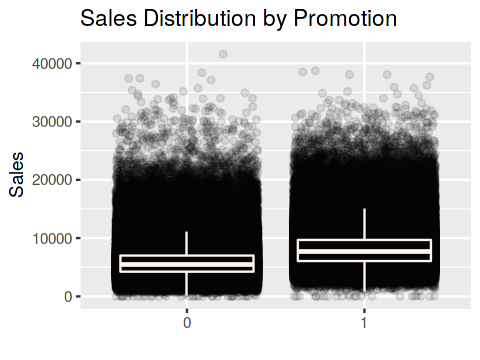

In [22]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of sales by Promotion
ggplot(train, aes(x = factor(Promo), y = Sales)) + 
  geom_jitter(alpha = 0.1) +
  geom_boxplot(color = "seashell", outlier.colour = NA, fill = NA) +
  labs(title="Sales Distribution by Promotion") +
  labs(x="", y="Sales")

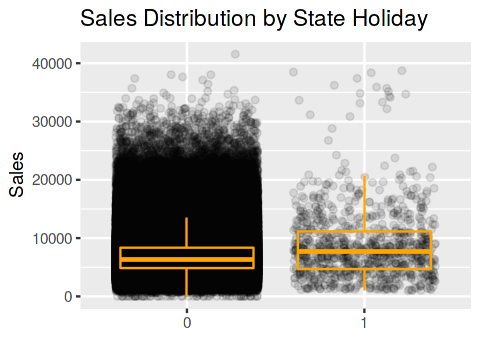

In [23]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of sales by State Holiday
ggplot(train, aes(x = factor(StateHoliday), y = Sales)) + 
  geom_jitter(alpha = 0.1) +
  geom_boxplot(color = "orange", outlier.colour = NA, fill = NA) +
  labs(title="Sales Distribution by State Holiday") +
  labs(x="", y="Sales")

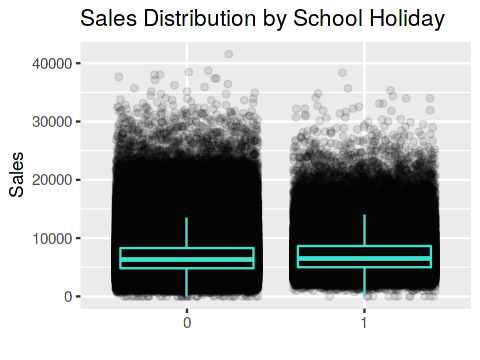

In [24]:
options(repr.plot.width=4, repr.plot.height=3)
# Distribution of sales by School Holiday
ggplot(train, aes(x = factor(SchoolHoliday), y = Sales)) + 
  geom_jitter(alpha = 0.1) +
  geom_boxplot(color = "turquoise", outlier.colour = NA, fill = NA) +
  labs(title="Sales Distribution by School Holiday") +
  labs(x="", y="Sales")

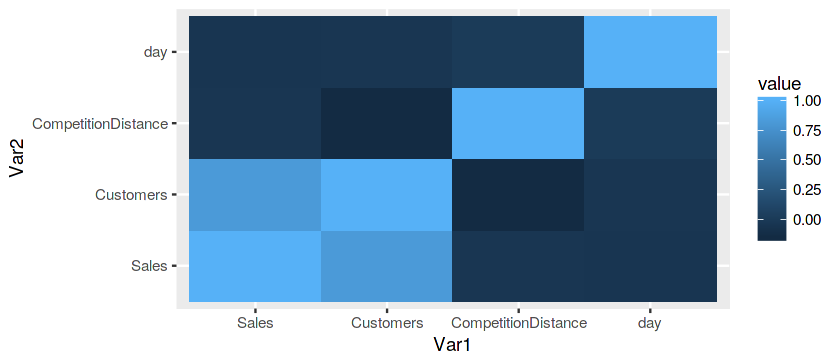

In [25]:
options(repr.plot.width=7, repr.plot.height=3)
# Creating a correlation heat map for the numeric vars
nums <- sapply(train, is.numeric)
cormat <- round(cor(train[,nums]),2)
melted_cormat <- melt(cormat)
ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()

In [43]:
# Removing the date column as required elements have been extracted
train <- train[,-c(3)]

### Feature Engineering

In [44]:
# Even though sales will vary from store to store, let's use average sales per store as a dummy variable
storeAvgSales <- train %>%
  group_by(Store) %>%
  summarise(store_avg_sales = mean(Sales))
# No. of customers itself can be a response variable to predict, so will use avg cust per mth per store
storeAvgCust <- train %>%
  group_by(Store, month) %>%
  summarise(store_avg_custpm = mean(Customers))
# Dummy for store type
storeTAvgSales <- train %>%
  group_by(StoreType) %>%
  summarise(storeType_avg_sales = mean(Sales))
# Dummy for assortment
AsmntAvgSales <- train %>%
  group_by(Assortment) %>%
  summarise(Asmnt_avg_sales = mean(Sales))

# Merging them back to the main dataset
train <- merge(train, storeAvgSales, by=c("Store"))
train <- merge(train, storeAvgCust, by=c("Store","month"))
train <- merge(train, storeTAvgSales, by=c("StoreType"))
train <- merge(train, AsmntAvgSales, by=c("Assortment"))

head(train)

Assortment,StoreType,Store,month,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,year,day,store_avg_sales,store_avg_custpm,storeType_avg_sales,Asmnt_avg_sales
a,a,395,3,6,2857,373,1,0,0,0,3620,2015,28,3989.135,520.5325,6925.168,6621.017
a,a,395,3,1,5164,642,1,1,0,0,3620,2015,2,3989.135,520.5325,6925.168,6621.017
a,a,1066,12,6,11444,1125,1,0,0,0,3350,2013,7,11073.919,1272.0612,6925.168,6621.017
a,a,445,2,2,5929,954,1,0,0,0,240,2013,26,8600.151,1165.4571,6925.168,6621.017
a,a,1066,12,1,19811,2121,1,0,0,1,3350,2013,23,11073.919,1272.0612,6925.168,6621.017
a,a,445,2,1,10170,1350,1,1,0,0,240,2013,18,8600.151,1165.4571,6925.168,6621.017


In [45]:
# Sampling a small subset to train due to resource limitations
n = nrow(train)
trainIndex = sample(1:n, size = 50000, replace=FALSE)
train = train[trainIndex ,]
summary(train)

 Assortment StoreType     Store           month       DayOfWeek     Sales      
 a:26342    a:27100   682    :   84   3      : 5086   1:8082    Min.   :    0  
 b:  512    b:  977   201    :   68   1      : 5066   2:8616    1st Qu.: 4876  
 c:23146    c: 6678   262    :   68   7      : 4999   3:8327    Median : 6367  
            d:15245   841    :   66   6      : 4985   4:8095    Mean   : 6972  
                      299    :   64   5      : 4870   5:8132    3rd Qu.: 8375  
                      705    :   64   4      : 4852   6:8527    Max.   :38037  
                      (Other):49586   (Other):20142   7: 221                   
   Customers    Open      Promo     StateHoliday SchoolHoliday
 Min.   :   0   1:50000   0:27723   0:49952      0:40460      
 1st Qu.: 520             1:22277   1:   48      1: 9540      
 Median : 676                                                 
 Mean   : 766                                                 
 3rd Qu.: 896                                

In [46]:
# Let's split the dataset into train and test - 70-30
n = nrow(train)
trainIndex = sample(1:n, size = round(0.7*n), replace=FALSE)
train = train[trainIndex ,]
test = train[-trainIndex ,]

# Extracting the candidate variables to build the model
feature.names <- names(train)[c(4,5,9:12,14:18)]
feature.names

[1] "month"               "DayOfWeek"           "Promo"              
 [4] "StateHoliday"        "SchoolHoliday"       "CompetitionDistance"
 [7] "day"                 "store_avg_sales"     "store_avg_custpm"   
[10] "storeType_avg_sales" "Asmnt_avg_sales"

### Model Development

In [47]:
# Building the Random Forest model
model_rf <- randomForest(train[,feature.names], 
                         train$Sales,
                         mtry=4,
                         ntree=20,
                         do.trace=TRUE)

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
   1 | 2.708e+06    27.47 |
   2 | 2.539e+06    25.75 |
   3 | 2.332e+06    23.65 |
   4 | 2.227e+06    22.59 |
   5 | 2.098e+06    21.28 |
   6 | 2.008e+06    20.37 |
   7 | 1.927e+06    19.54 |
   8 | 1.844e+06    18.70 |
   9 | 1.757e+06    17.82 |
  10 | 1.719e+06    17.44 |
  11 | 1.665e+06    16.88 |
  12 | 1.63e+06    16.53 |
  13 | 1.597e+06    16.20 |
  14 | 1.579e+06    16.02 |
  15 | 1.551e+06    15.73 |
  16 | 1.527e+06    15.49 |
  17 | 1.511e+06    15.33 |
  18 | 1.493e+06    15.14 |
  19 | 1.483e+06    15.04 |
  20 | 1.469e+06    14.90 |


[1] "model stats:"



Call:
 randomForest(x = train[, feature.names], y = train$Sales, ntree = 20,      mtry = 4, do.trace = TRUE) 
               Type of random forest: regression
                     Number of trees: 20
No. of variables tried at each split: 4

          Mean of squared residuals: 1469264
                    % Var explained: 85.1

[1] "Training RMSE:"
[1] 1353.971


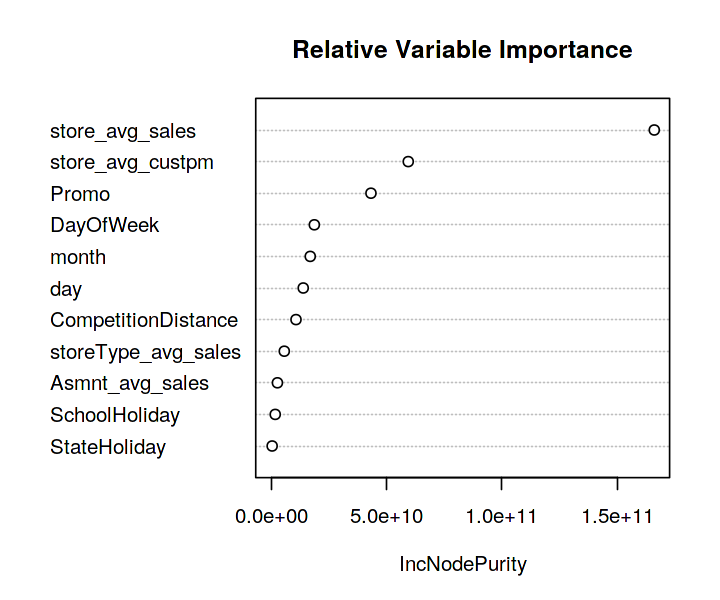

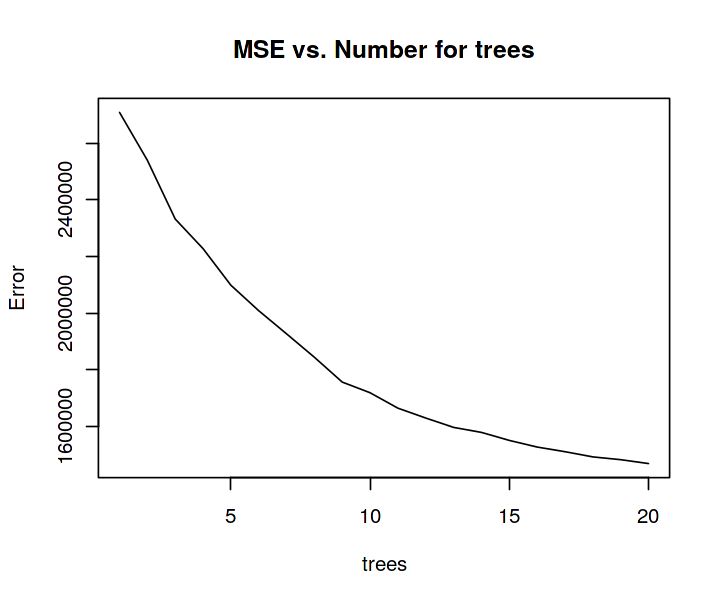

In [48]:
# Assessing the model performance
print("model stats:");model_rf
print("Training RMSE:");print(sqrt(mean(model_rf$mse)))
options(repr.plot.width=6, repr.plot.height=5)
varImpPlot(model_rf, main="Relative Variable Importance")
plot(model_rf, main="MSE vs. Number for trees")

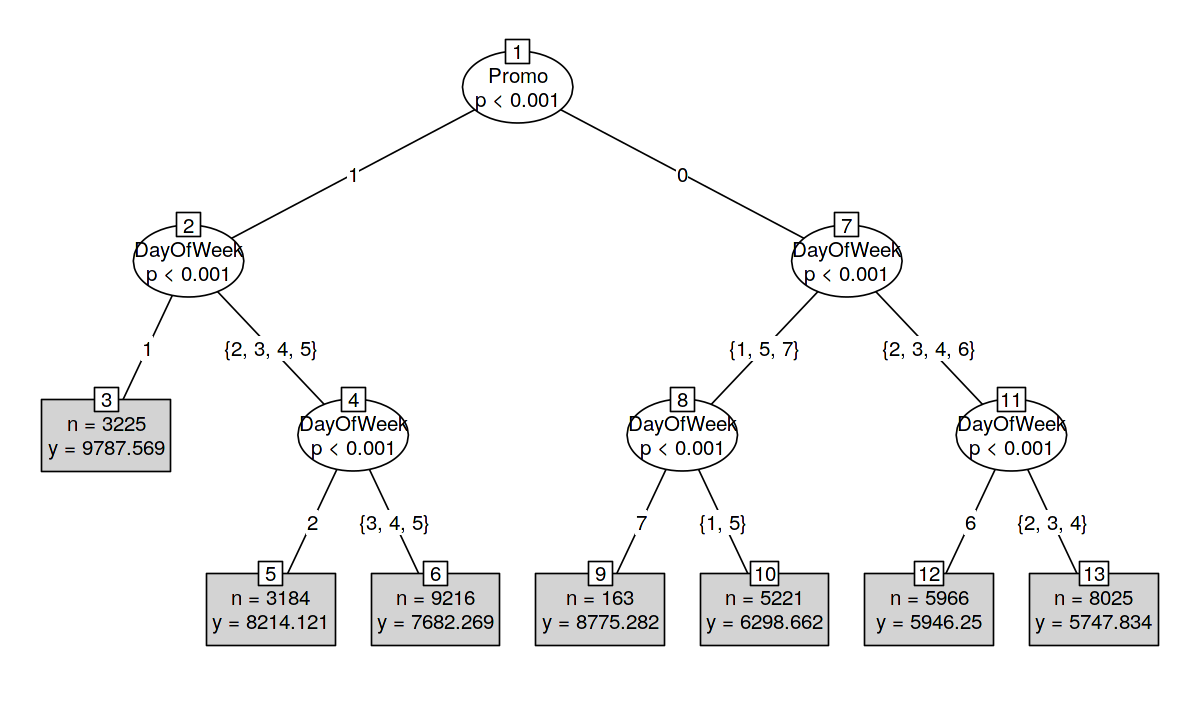

In [49]:
options(repr.plot.width=10, repr.plot.height=6)
# Plotting a simple conditional tree to demonstrate the Random Forest internal splitting
demoT <- ctree(Sales ~ Promo + DayOfWeek, data=train)                                    
plot(demoT, type="simple")

### Prediction & Validation

In [50]:
# Prediction using Test data
summary(test)
pred <- predict(model_rf, test[,feature.names])
print("Test RMSE:");print(sqrt(mean((test$Sales-pred)^2)))
print("MAPE:");print(mean(abs((test$Sales-pred)/test$Sales) * 100))
print("RMSPE:");print(sqrt(mean(((test$Sales-pred)/test$Sales)^2)) * 100)

 Assortment StoreType     Store           month      DayOfWeek     Sales      
 a:5564     a:5767    682    :   24   7      :1113   1:1688    Min.   :  538  
 b: 114     b: 215    130    :   20   1      :1061   2:1755    1st Qu.: 4937  
 c:4867     c:1419    361    :   20   6      :1061   3:1733    Median : 6410  
            d:3144    262    :   19   2      :1042   4:1765    Mean   : 6986  
                      299    :   19   3      :1035   5:1736    3rd Qu.: 8365  
                      331    :   19   5      :1028   6:1816    Max.   :31899  
                      (Other):10424   (Other):4205   7:  52                   
   Customers      Open      Promo    StateHoliday SchoolHoliday
 Min.   :  77.0   1:10545   0:5876   0:10538      0:8543       
 1st Qu.: 523.0             1:4669   1:    7      1:2002       
 Median : 680.0                                                
 Mean   : 770.2                                                
 3rd Qu.: 898.0                                 

[1] "Test RMSE:"
[1] 569.846
[1] "MAPE:"
[1] 6.040607
[1] "RMSPE:"
[1] 9.089537
